# Comparison between mock-based + analytic covariance

We compare the analytic calculation of the Gaussian covariance for a survey with a given $\bar{n}$ to the mock-based results for the 84 N-cutsky mocks and the 1000 eBOSS DR14Q EZ mocks. 

See the ``theory.ipynb`` notebook in this directory for the analytic calculation.

**Notes**
- there are 84 N-cutsky mocks
- there are 1000 EZ mocks
- no redshift evolution for N-cutsky mocks
- there is redshift evolution for EZ mocks
- analytic calculation for N-cutsky mocks agrees either when using best-fit model, or P(k,mu) measured from the underlying periodic cubic boxes
- no cubic boxes for EZ mocks so we are using simple Kaiser multipoles with expected $b(z)$ to predict analytic covariance
- analytic calculation appears to over-estimate covariance by a near-constant amount across multiple simulations (bug?)


**A bug?**

Our analytic estimates agree well with Eq 25 of [Yamamoto et al. 2006](https://arxiv.org/abs/astro-ph/0505115) which is the derivation for the minimum error for the estimator we are using. This minimum error is greater than the mock-based covariance though, which maybe suggests a bug in the code somewhere?

In [1]:
from pyRSD.rsdfit.data import PoleCovarianceMatrix
from nbodykit import style

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

# N-cutsky comparison

In [17]:
def plot(sim, ells):
    
    if sim == 'ncutsky':
        C1 = PoleCovarianceMatrix.from_plaintext('../results/covariance/ncutsky_mock_cov_02.dat')
        C2 = PoleCovarianceMatrix.from_plaintext('../results/covariance/ncutsky_analytic_cov_from_data_02.dat')
    else:
        sample = sim.split('-')[-1]
        C1 = PoleCovarianceMatrix.from_plaintext('../results/covariance/eboss_%s_mock_cov_02.dat' %sample)
        C2 = PoleCovarianceMatrix.from_plaintext('../results/covariance/eboss_%s_analytic_cov_evolve_02.dat' %sample)
        
    for ell in ells:
        a = C1.sel(ell1=ell, ell2=ell)
        b = C2.sel(ell1=ell, ell2=ell)

        plt.plot(a.ks(), a.diag/b.diag, label="$\ell_1 = \ell_2 = %d$" %ell)
    
    plt.legend()
    plt.xlabel(r"$k$ $[h/\mathrm{Mpc}]$")
    plt.ylabel(r"$C^\mathrm{mock} / C^\mathrm{analytic}$")
    return plt.gca()

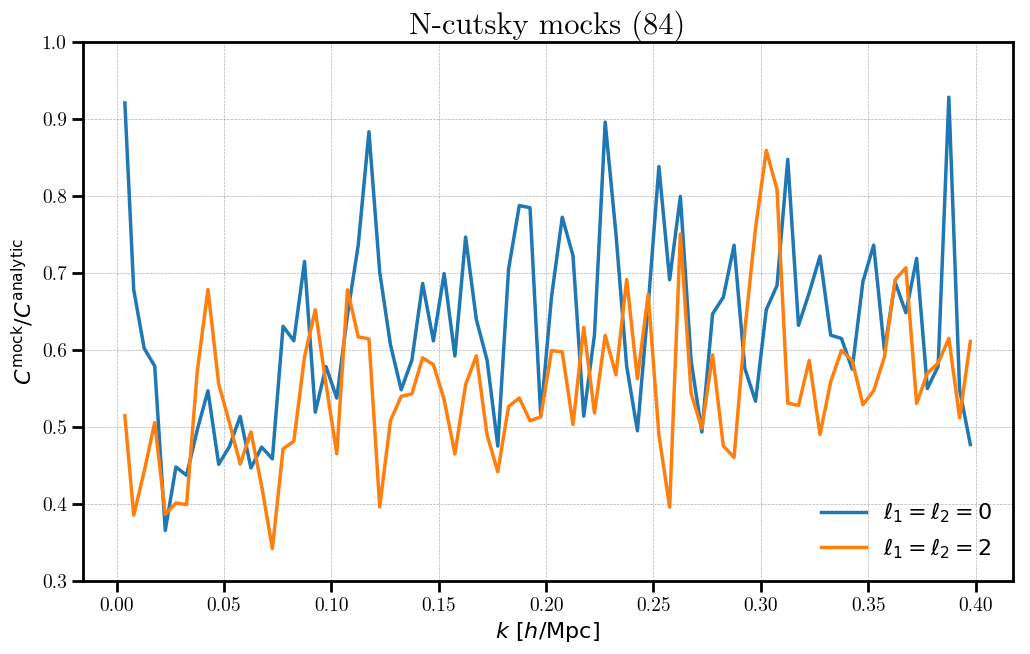

In [27]:
ax = plot('ncutsky', [0,2])
ax.set_ylim(0.3, 1.0)
ax.set_title("N-cutsky mocks (84)")
plt.show()

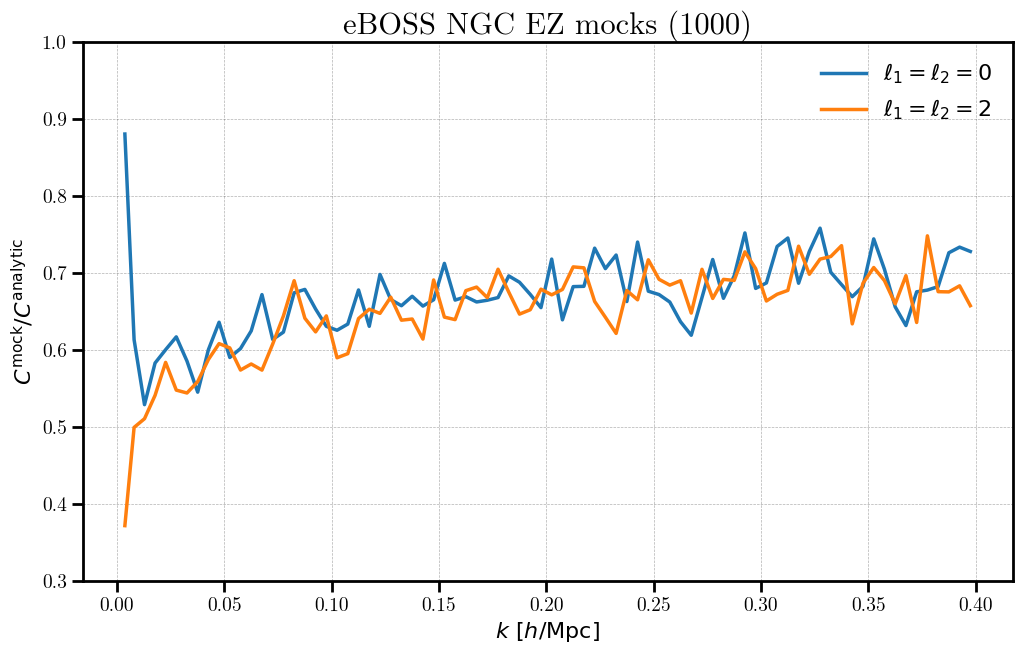

In [25]:
ax = plot('eboss-N', [0,2])
ax.set_ylim(0.3, 1.0)
ax.set_title("eBOSS NGC EZ mocks (1000)")
plt.show()

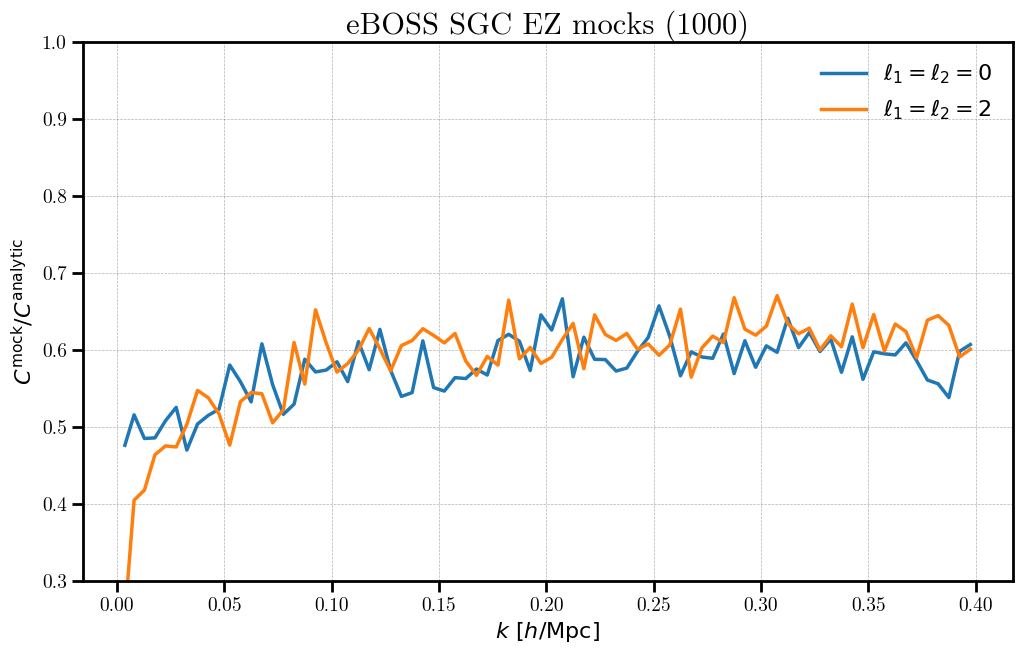

In [26]:
ax = plot('eboss-S', [0,2])
ax.set_ylim(0.3, 1.0)
ax.set_title("eBOSS SGC EZ mocks (1000)")
plt.show()